# Tree based models
In this notebook, we will use bagging, boosting and random forest to try to improve the best baseline model - LogReg


In [11]:
import numpy as np
import pandas as pd
import pyarrow.parquet as pq #source: https://arrow.apache.org/docs/python/parquet.html
from sklearn.model_selection import train_test_split #source: KNN-Creditrisk
from sklearn.model_selection import GridSearchCV #source: treeModels.ipynb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.inspection import permutation_importance, PartialDependenceDisplay

# Fix: Use relative path and specify engine to avoid pyarrow extension type conflict
parquet_path = Path("datasets/computed/metacritic_sales_tier_modelling.parquet")
df_base = pd.read_parquet(parquet_path, engine='fastparquet')

### Data preparation 
To use the tree based models, we first create a train/validation and testset. Let's do this the professional way and do this with *object oriented programming*.  (Source: KNN-Creditrisk) 

#### Creating the train, test, and validation splits (source: KNN notebook)

- **We split the dataset into train, validation, and test**

- We will set test aside, which will be used to evaluate the final performance of the model. Then we will use train and validation to fit the actual model.

- Note: We use stratisfied sampling since we want to make sure that the distribution of sales tiers is equal in train/validate/test

In [12]:
pd.set_option('display.max_columns', None) #it compresses the view, so this neat trick helps :)
df_base.head() #quick look at the final modelling dataset

,movie_id,metascore,userscore,runtime,production_budget_log,theatre_count_log,release_year,genre_list,genre_Action,genre_Adult,genre_Adventure,genre_Animation,genre_Biography,genre_Black Comedy,genre_Comedy,genre_Concert/Performance,genre_Crime,genre_Documentary,genre_Drama,genre_Educational,genre_Family,genre_Fantasy,genre_History,genre_Horror,genre_Multiple Genres,genre_Music,genre_Musical,genre_Mystery,genre_News,genre_Reality,genre_Romance,genre_Romantic Comedy,genre_Sci-Fi,genre_Short,genre_Sport,genre_Thriller,genre_Thriller/Suspense,genre_Unknown,genre_War,genre_Western,rating_missing,rating_clean,rating_G,rating_NC-17,rating_Not Rated,rating_PG,rating_PG-13,rating_R,season_Fall,season_Spring,season_Summer,season_Winter,summer_release,holiday_release,user_embed_1,user_embed_2,user_embed_3,user_embed_4,user_embed_5,user_embed_6,user_embed_7,user_embed_8,user_embed_9,user_embed_10,expert_embed_1,expert_embed_2,expert_embed_3,expert_embed_4,expert_embed_5,expert_embed_6,expert_embed_7,expert_embed_8,expert_embed_9,expert_embed_10,sales_tier_encoded
0,6305dc82622a,59.0,6.7,129.0,16.993564,4.262680,2000.0,[Drama],0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,Not Rated,False,False,True,False,False,False,False,False,False,True,0,0,4.791063,0.105657,-0.019576,-0.004482,0.081379,0.002436,0.027291,0.004146,0.047220,-0.040455,5.248415,-0.013454,-0.028619,0.025156,-0.031859,-0.024816,-0.012283,-0.021413,0.034195,-0.025543,0
1,662bc1e3cf57,31.0,8.7,109.0,17.216708,7.797291,2001.0,"[Drama, Thriller]",0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,PG-13,False,False,False,False,True,False,False,False,False,True,0,0,-22.518179,7.926952,-4.374372,-5.471427,4.792280,-5.970364,1.263540,-1.506532,4.172362,4.004245,-18.119719,-5.644859,6.622465,5.285645,-4.129042,-17.439384,-4.432830,6.081197,-1.913313,3.629471,2
2,dfc233d7a2f9,59.0,6.7,104.0,16.213406,7.788212,2002.0,[Drama],0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,Not Rated,False,False,True,False,False,False,False,False,False,True,0,0,4.791063,0.105657,-0.019576,-0.004482,0.081379,0.002436,0.027291,0.004146,0.047220,-0.040455,5.248415,-0.013454,-0.028619,0.025156,-0.031859,-0.024816,-0.012283,-0.021413,0.034195,-0.025543,2
3,ed1dd3e75880,41.0,6.4,104.0,16.906553,7.812378,2008.0,"[Thriller, Comedy, Romance, Crime]",0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,PG-13,False,False,False,False,True,False,False,False,False,True,0,0,-23.572487,2.176041,2.813654,1.120385,-7.183623,0.716902,6.641965,4.013510,7.728705,1.252990,-19.683950,-6.086373,-7.251342,6.611788,1.355806,1.178939,-1.492724,4.369090,3.527283,1.824804,2
4,8e3d5b8714f4,30.0,5.1,95.0,16.118096,7.589842,2008.0,"[Fantasy, Comedy, Romance]",0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,PG-13,False,False,False,False,True,False,False,False,False,True,0,0,-19.584745,-9.910595,-4.104996,7.199965,7.064362,-3.296383,5.574745,4.356566,0.314410,-4.770975,-22.277643,-4.169212,-3.627316,4.190808,-9.552444,-1.246047,4.286777,-1.451442,5.136322,2.053113,2


We can see here that the dataset has a bunch of different characteristics that we can and cannot use. 
1. The dataset still has string data instead of numeric 
2. The dataset has both features and embeddings, so we can use the dataset with and without the embeddings to see if the reviews have any impact on model performance.
3. The target is encoded in three classes to we have to use stratisfied sampling

In the following codeblock, we use object oriented programming to 

In [13]:
# First we initialize the splitter, which is basically the settings of the splitter 
# We want to get 80% of the data for training, and 20% for testing
# To do this, we first set the fraction for training to 0.64 since 0.8*0.8= 0.64 (80% of the 80% for training)
# Then we create the validation fraction which is 20% of the initial 80% training dat, so 1-0.64 = 0.16
# the "rest" of the data is the testset 
class TrainTestSplitter: 
    def __init__(self, train_frac=0.64, val_frac=0.16, seed=42): #initialize the object, with 64% training data, 16% validation
        self.train_frac = train_frac # Use the self statement to let the function remember the settings
        self.val_frac = val_frac 
        self.seed = seed #Make sure that the first and the second split use the same starting point

    def split_data(self, df, target_col):
        """
        Split the data into train, validation and test sets using stratisfied sampling
        The split first splits the test set from the full dataframe and then splits the remaining data into train and validation
        
        :param self: provides the settings and stores the results
        :param df: The full modelling dataframe
        :param target_col: The column used for stratification

        Returns:
        train_set, validation_set, test_set
        """
          
        print(f"Splitting data based on target: {target_col}...") #the function prints some text and the column that we do stratification on
        
        # Calculate the fraction that is not the trainset or validation set to find the testset
        test_frac = 1.0 - (self.train_frac + self.val_frac)
        
        # First split is the training dataset
        # 'temp_df' contains both the train and validation set for a moment
        temp_df, self.test_set = train_test_split(
            df, 
            test_size=test_frac, 
            random_state=self.seed, 
            stratify=df[target_col]
        )
        
        # 3. Calculate the relative size for the second split
        relative_val_size = self.val_frac / (self.train_frac + self.val_frac)
        
        # 4. Second Split: Separate Train and Validation from temp_df
        self.train_set, self.validation_set = train_test_split(
            temp_df, 
            test_size=relative_val_size, 
            random_state=self.seed, 
            stratify=temp_df[target_col]
        )
        
        # 5. Clean up the indexes (so they start at 0, 1, 2...)
        self.train_set = self.train_set.reset_index(drop=True)
        self.validation_set = self.validation_set.reset_index(drop=True)
        self.test_set = self.test_set.reset_index(drop=True)

        print(f"Split completed. Train: {len(self.train_set)}, Val: {len(self.validation_set)}, Test: {len(self.test_set)}")
        
        return self.train_set, self.validation_set, self.test_set

Now we actually create a splitter object

In [14]:
# 1. Create the 'splitter' object from the class
# We will use 64% for training and 16% for validation
splitter = TrainTestSplitter(train_frac=0.64, val_frac=0.16, seed=42)

# 2. We run the split_data method and tell it the target is 'sales_tier_encoded'
train, val, test = splitter.split_data(df_base, target_col='sales_tier_encoded')

# 3. Double checking a specific tier to see if stratification worked
print("\nProportion of tiers in Training Set:")
print(train['sales_tier_encoded'].value_counts(normalize=True))

print("\nProportion of tiers in Test Set:")
print(test['sales_tier_encoded'].value_counts(normalize=True))

Splitting data based on target: sales_tier_encoded...
Split completed. Train: 13932, Val: 3484, Test: 4354

Proportion of tiers in Training Set:
sales_tier_encoded
1    0.340009
2    0.330032
0    0.329960
Name: proportion, dtype: float64

Proportion of tiers in Test Set:
sales_tier_encoded
1    0.339917
2    0.330041
0    0.330041
Name: proportion, dtype: float64


The split worked perfectly, both the training and the testset have equal propotions of all the sales tiers. 

Now we create the dataframes that hold the data we want to use for modelling by separating the target from the features:
- X_train = All the data from the training set without the target
- Y_train = The target data 

- X_val = All the data from the validation set without the target
- Y_val = The target data in the validation set

- X_test = All the data from the validation set without the target
- Y_test = The target data in the test set

NOTE: Tree based models only work with numeric data. We will therefore drop the data that has non-numeric data


In [15]:
pd.set_option('display.max_rows', None) #it compresses the view, very anoying actually
df_base.dtypes #print the datatypes to see which ones dont work for the bagged trees

movie_id                      object
metascore                    float64
userscore                    float64
runtime                      float64
production_budget_log        float64
theatre_count_log            float64
release_year                 float64
genre_list                    object
genre_Action                   int64
genre_Adult                    int64
genre_Adventure                int64
genre_Animation                int64
genre_Biography                int64
genre_Black Comedy             int64
genre_Comedy                   int64
genre_Concert/Performance      int64
genre_Crime                    int64
genre_Documentary              int64
genre_Drama                    int64
genre_Educational              int64
genre_Family                   int64
genre_Fantasy                  int64
genre_History                  int64
genre_Horror                   int64
genre_Multiple Genres          int64
genre_Music                    int64
genre_Musical                  int64
g

Now we create the target and the features. A few important notes here: 
1. The object datatypes will be removed. e.g. the Rating_clean and genre_list does not make any sense since they have been on hot encoded and the id has no predictive power anyway
2. The boolean types are converted to numbers

In [16]:
# 1. Create the target (y)
y_train = train['sales_tier_encoded']
y_validation = val['sales_tier_encoded']

# 2. Create the features (X)
# We exclude 'object' to remove movie_id, genre_list, and rating_clean automatically
X_train = train.drop(columns=['sales_tier_encoded']).select_dtypes(exclude=['object'])
X_validation = val.drop(columns=['sales_tier_encoded']).select_dtypes(exclude=['object'])

# 3. Convert booleans (true/false) to numbers (1/0)
# This makes it easier for the bagging model to calculate 
X_train = X_train.astype(float)
X_validation = X_validation.astype(float)

print(f"Success! We are using {X_train.shape[1]} features.")


Success! We are using 71 features.


In [17]:
y_test = test["sales_tier_encoded"] #The target column in the testset
X_test = test.drop(columns=["sales_tier_encoded"]).select_dtypes(exclude=["object"]).astype(float) # All the other data in the testset without the object data

# ensure same columns/order as training
X_test = X_test.reindex(columns=X_train.columns, fill_value=0.0)


In [18]:
X_train.head()

#sanity check

,metascore,userscore,runtime,production_budget_log,theatre_count_log,release_year,genre_Action,genre_Adult,genre_Adventure,genre_Animation,genre_Biography,genre_Black Comedy,genre_Comedy,genre_Concert/Performance,genre_Crime,genre_Documentary,genre_Drama,genre_Educational,genre_Family,genre_Fantasy,genre_History,genre_Horror,genre_Multiple Genres,genre_Music,genre_Musical,genre_Mystery,genre_News,genre_Reality,genre_Romance,genre_Romantic Comedy,genre_Sci-Fi,genre_Short,genre_Sport,genre_Thriller,genre_Thriller/Suspense,genre_Unknown,genre_War,genre_Western,rating_missing,rating_G,rating_NC-17,rating_Not Rated,rating_PG,rating_PG-13,rating_R,season_Fall,season_Spring,season_Summer,season_Winter,summer_release,holiday_release,user_embed_1,user_embed_2,user_embed_3,user_embed_4,user_embed_5,user_embed_6,user_embed_7,user_embed_8,user_embed_9,user_embed_10,expert_embed_1,expert_embed_2,expert_embed_3,expert_embed_4,expert_embed_5,expert_embed_6,expert_embed_7,expert_embed_8,expert_embed_9,expert_embed_10
0,50.0,6.9,90.0,16.993564,4.26268,2017.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,-22.072214,-3.350949,2.071532,8.362472,9.307377,3.082520,1.040087,-0.247562,-0.797200,-4.038525,-20.344713,5.514405,-6.495228,2.690563,-5.935856,-2.313581,-1.974514,-1.398360,1.969382,-3.230158
1,59.0,6.7,96.0,16.993564,4.26268,2021.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,4.791063,0.105657,-0.019576,-0.004482,0.081379,0.002436,0.027291,0.004146,0.047220,-0.040455,5.248415,-0.013454,-0.028619,0.025156,-0.031859,-0.024816,-0.012283,-0.021413,0.034195,-0.025543
2,59.0,6.7,82.0,16.993564,4.26268,2021.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4.791063,0.105657,-0.019576,-0.004482,0.081379,0.002436,0.027291,0.004146,0.047220,-0.040455,5.248415,-0.013454,-0.028619,0.025156,-0.031859,-0.024816,-0.012283,-0.021413,0.034195,-0.025543
3,59.0,6.7,90.0,16.993564,4.26268,2015.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,4.791063,0.105657,-0.019576,-0.004482,0.081379,0.002436,0.027291,0.004146,0.047220,-0.040455,5.248415,-0.013454,-0.028619,0.025156,-0.031859,-0.024816,-0.012283,-0.021413,0.034195,-0.025543
4,56.0,8.0,99.0,16.993564,4.26268,2020.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,-19.036177,-3.183167,-2.557212,-1.681025,12.416853,-9.977543,-0.942114,-2.781208,2.153989,0.649213,-20.343374,0.868960,-5.471694,2.868397,-2.174418,-3.040885,-1.008885,-6.594128,-6.573283,-4.448895


# Bagged trees 
In this chapter, we build a bagged tree with hyperparameter tuning and see which features come out on top. 
- Build an initial decision tree as a baseline
- Use the bagging classifier to build 50 trees
- Use a gridsearch for hyperparameter tuning
- Check the top 20 permutated features and confusion matrix

In [19]:
# 1. Initialize the base tree 
# We use a decision tree as the individual "voter" in the crowd
base_tree = DecisionTreeClassifier(random_state=1234)

# 2. Initialize the bagging classifier
# We build 50 trees at first
bagging_model = BaggingClassifier(
    estimator=base_tree, 
    n_estimators=50, 
    random_state=1234
)

# 3. Fit the model (This is the training phase)
# The model "studies" the relationship between X features and y sales tiers
bagging_model.fit(X_train, y_train)

# 4. Make predictions on the validation set
# We use X_validation to see how well the model learned
y_pred_val = bagging_model.predict(X_validation)

# 5. Evaluate the results
val_accuracy = accuracy_score(y_validation, y_pred_val)
print(f"Validation Accuracy: {val_accuracy:.2%}")
print("\nDetailed Report:")
print(classification_report(y_validation, y_pred_val))

Validation Accuracy: 57.35%

Detailed Report:
              precision    recall  f1-score   support

           0       0.54      0.58      0.56      1150
           1       0.46      0.46      0.46      1185
           2       0.74      0.68      0.70      1149

    accuracy                           0.57      3484
   macro avg       0.58      0.57      0.58      3484
weighted avg       0.58      0.57      0.58      3484



#### Model interpretation: initial bagging results
Our first model used a Bagging Classifier with 50 Decision Trees. With a baseline for random guessing at 33.3% (for three balanced classes), the model's accuracy of 57.35% shows big improvement. However, the baseline model logisticregression did almost just as good. Some interpretation:

- Tier 2: This is the model’s strongest area. A Precision of 73% suggests that the highest movie performers have very unique feature. This will probably be a high budget or maybe even very good expert reviews.

- Tier 0: The model is moderately successful here (56% F1-score). It can identify "flops" or niche movies with average reliability.

- Tier 1: This is the most difficult category. The low precision (46%) suggests that mid-tier movies often "look" like either low-tier or high-tier movies to the model.

Now we use grid search for hyperparameter tuning to find a configuration of the hyperparameters that performs the best. 

In [20]:
#Gridsearch for the bagged trees (source: treemodels.ipynb)
# hyperparameter tuning with crossvalidation of a random forest model
# 1. Define the "Grid" of settings
# The max_samples is used for BAGGED trees, in random forest we use max_features
# Base tree that will be bagged
base_tree = DecisionTreeClassifier(random_state=1234)

bagged = BaggingClassifier(
    estimator=base_tree,
    random_state=1234,
    n_jobs=-1
)

param_grid_baggedtree = {
    "n_estimators": [100, 200],
    "max_samples": [0.6, 0.8, 1.0],           # fraction of rows per tree
    "max_features": [0.6, 0.8, 1.0],          # fraction of features per tree
    "estimator__max_depth": [10, 20, None],   # goes to the DecisionTree
    "estimator__min_samples_split": [2, 5, 10]
}

grid_search_baggedtree = GridSearchCV(
    estimator=bagged,
    param_grid=param_grid_baggedtree,
    cv=3,
    scoring="accuracy",
    verbose=2,
    n_jobs=-1
)

print("Starting the search for the best hyperparameters...")
grid_search_baggedtree.fit(X_train, y_train)

best_baggedtree = grid_search_baggedtree.best_estimator_
y_pred_tuned = best_baggedtree.predict(X_validation)

print(f"\nBest settings found: {grid_search_baggedtree.best_params_}")
print(f"Tuned bagged tree accuracy: {accuracy_score(y_validation, y_pred_tuned):.2%}")
print("\nDetailed tuned report:")
print(classification_report(y_validation, y_pred_tuned))




Starting the search for the best hyperparameters...
Fitting 3 folds for each of 162 candidates, totalling 486 fits
[CV] END estimator__max_depth=10, estimator__min_samples_split=2, max_features=0.6, max_samples=0.6, n_estimators=100; total time=   2.7s
[CV] END estimator__max_depth=10, estimator__min_samples_split=2, max_features=0.6, max_samples=0.6, n_estimators=100; total time=   3.0s
[CV] END estimator__max_depth=10, estimator__min_samples_split=2, max_features=0.6, max_samples=0.6, n_estimators=100; total time=   3.0s
[CV] END estimator__max_depth=10, estimator__min_samples_split=2, max_features=0.6, max_samples=0.8, n_estimators=100; total time=   3.2s
[CV] END estimator__max_depth=10, estimator__min_samples_split=2, max_features=0.6, max_samples=0.8, n_estimators=100; total time=   3.1s
[CV] END estimator__max_depth=10, estimator__min_samples_split=2, max_features=0.6, max_samples=0.6, n_estimators=200; total time=   5.0s
[CV] END estimator__max_depth=10, estimator__min_samples_

The gridsearch took quite some time, but the accuracy of the bagged tree model is significantly higher then before. Now we fit the best baggedtree on the test and validation set and show the confusion matrix and permutated feature importance plots. 

--- FINAL TEST PERFORMANCE (trained on training and validation data) ---
Accuracy: 61.55%
              precision    recall  f1-score   support

           0       0.55      0.71      0.62      1437
           1       0.51      0.47      0.49      1480
           2       0.84      0.67      0.74      1437

    accuracy                           0.62      4354
   macro avg       0.64      0.62      0.62      4354
weighted avg       0.63      0.62      0.62      4354



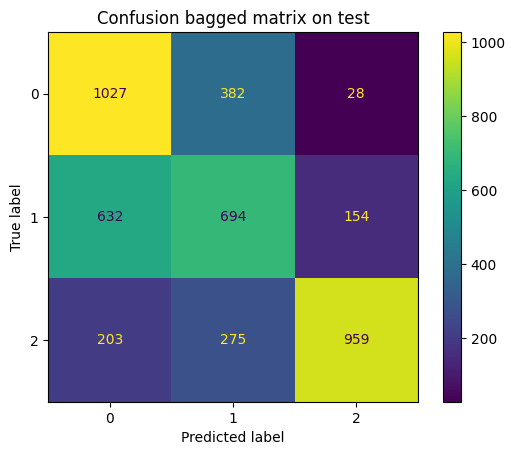

In [21]:
final_baggedmodel = best_baggedtree 

X_trainval = pd.concat([X_train, X_validation], axis=0) #add the training features to the validation features
y_trainval = pd.concat([y_train, y_validation], axis=0) #add the training target to the validation target

final_baggedmodel.fit(X_trainval, y_trainval) #fit the best model on both training and validation 

y_pred_bagged = final_baggedmodel.predict(X_test) #Let's see how wel it does

print("--- FINAL TEST PERFORMANCE (trained on training and validation data) ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_bagged):.2%}")
print(classification_report(y_test, y_pred_bagged))

ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_bagged, values_format="d"
)
plt.title("Confusion bagged matrix on test")
plt.show()

**Conclusion** 

The best bagged tree model predicts low and high sales a lot better than medium sales. On the test set, the model achieves an overall accuracy of 61.55%, which shows it has learned meaningful patterns, but it still makes many mistakes. In the confusion matrix, it can be seen that: 

- In the low sales category, the model correctly predicted 1027 from the 1437. The model predicted 382 movies that should be low tier sales as medium tier sales and 28 as high tier sales. 

- High sales are also predicted quite well! When the model predicts high sales, it is often correct. Interestingly, quite some movies that should be in high tier were actually predicted as low tier. This is a big misclassification and, given that the most important feature is by far the theatre count, could mean that some movies sold very well despite having a low theatre count. 

- The biggest weakness is medium sales: only 694 medium-sales titles are correctly classified, while many are misclassified as low sales (632) or high sales (154). This is not very surprising since these movies will probably have similar feature spaces. 

# Random forest + hyperparameter tuning

In this chapter, we build a random forest with hyperparameter tuning and see which features come out on top. 
- Build an initial random forest as a baseline
- Use the randomforest classifier to build 100 trees
- Use a gridsearch for hyperparameter tuning
- Check the top 20 built-in features and permutated features

In [22]:
# 1. Initialize the baseline random forest with standard settings
# We use 100 trees (the default) to see the baseline performance
rf_baseline = RandomForestClassifier(n_estimators=100, random_state=1234)

# 2. Fit the model
rf_baseline.fit(X_train, y_train)

# 3. Predict on the validation set
y_pred_rf = rf_baseline.predict(X_validation)

# 4. Results
rf_acc = accuracy_score(y_validation, y_pred_rf)
print(f"Random forest baseline accuracy: {rf_acc:.2%}")
print(f"Improvement over Bagging: {rf_acc - 0.5726:.2%}") # the initial bagging model accuracy
print("\nDetailed Report:")
print(classification_report(y_validation, y_pred_rf))

Random forest baseline accuracy: 56.54%
Improvement over Bagging: -0.72%

Detailed Report:
              precision    recall  f1-score   support

           0       0.54      0.55      0.55      1150
           1       0.46      0.45      0.46      1185
           2       0.70      0.69      0.70      1149

    accuracy                           0.57      3484
   macro avg       0.57      0.57      0.57      3484
weighted avg       0.57      0.57      0.57      3484



#### The random forest did not do better
The model did slightly worse then the bagged tree, with a baseline accuracy of 56.54%. Interesting:

- Tier 2 is still the best tier to predict. So even when then model only sees random features they still stand out

- Tier 1 remains stuck at a 0.46 F1-score. This indicates that the "confusion" isn't necessarily because the model is looking at too many features, but perhaps because the data for Tier 1 and Tier 0 looks very similar.

Now we will use hyperparameter tuning to find the best settings for the random forest, it could very well be the case that the tree was overfitting. We will use a similar size grid as the bagged tree for consistency

In [23]:
# 1. Define the "Grid" of settings
# We are testing: 
# - More trees (200) vs fewer (100)
# - Shallow trees (10) vs Deep trees (20) vs Infinite (None)
# - How picky the tree is before making a new branch (min_samples_split)
param_grid_randomforest = {
    "n_estimators": [100, 200],                 
    "max_depth": [10, 20, None],
    "min_samples_split": [2, 5, 10, 20],
    "min_samples_leaf": [1, 2, 4],  
    "max_features": ["sqrt", "log2"]
}

# 2. Initialize the Grid Search
# n_jobs=-1 tells your computer to use all its "brains" (cores) to work faster
grid_search_randomforest = GridSearchCV(
    estimator=RandomForestClassifier(random_state=1234),
    param_grid=param_grid_randomforest,
    cv=3, 
    scoring='accuracy',
    verbose=2, 
    n_jobs=-1
)

# 3. Fit the search
print("Starting the search for the best hyperparameters...")
grid_search_randomforest.fit(X_train, y_train)

# 4. Extract the winner
best_rf = grid_search_randomforest.best_estimator_
y_pred_tuned = best_rf.predict(X_validation)

# 5. Final Comparison
print(f"\nBest Settings Found: {grid_search_randomforest.best_params_}")
print(f"Tuned random forest accuracy: {accuracy_score(y_validation, y_pred_tuned):.2%}")
print("\nDetailed Tuned Report:")
print(classification_report(y_validation, y_pred_tuned))

Starting the search for the best hyperparameters...
Fitting 3 folds for each of 144 candidates, totalling 432 fits
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.9s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.9s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.9s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.9s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.8s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.6s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.8s
[CV] END max_depth=10, max_features=sqrt, min

### Analysis of grid search:
1. The grid search found a configuration of the hyperparameters that balances the training and the generalization of the data. This results in a 5.23% increase in accuracy!

The model performed the best with 200 trees with a maximum depth to 20. Furthermore, the model required at least 10 samples to make a split, this acted as regularization, forcing the model to ignore outliers and focus on patterns.

2. The results is a typical example of the bias variance tradeoff. By limiting the depth of the trees and making sure they need more 10 samples to make a split, we reduced the model's variance. The high precision in the top tier indicates that this model is very useful for identifying potential blockbusters, even if the average performance movies are still hard to predict.

Last step: fitting both the training and validationset on the unseen data in the testset and showing the confusion matrix.



--- FINAL TEST PERFORMANCE (trained on training and validation data) ---
Accuracy: 60.75%
              precision    recall  f1-score   support

           0       0.57      0.68      0.62      1437
           1       0.50      0.47      0.49      1480
           2       0.80      0.67      0.73      1437

    accuracy                           0.61      4354
   macro avg       0.62      0.61      0.61      4354
weighted avg       0.62      0.61      0.61      4354



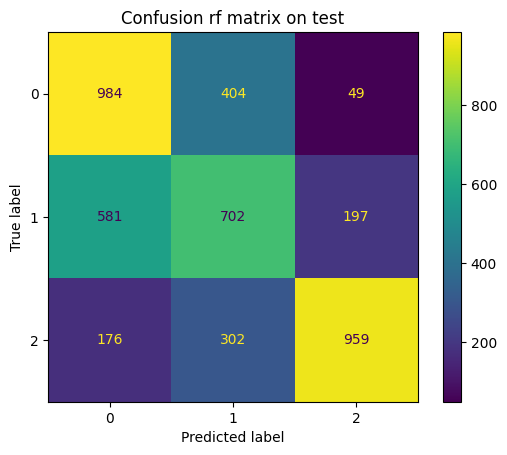

In [24]:
final_rf = best_rf 

final_rf.fit(X_trainval, y_trainval) #fit the best rf on both training and validation 

y_pred_rf = final_rf.predict(X_test) #Let's see how well it does

print("--- FINAL TEST PERFORMANCE (trained on training and validation data) ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.2%}")
print(classification_report(y_test, y_pred_rf))

ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_rf, values_format="d"
)
plt.title("Confusion rf matrix on test")
plt.show()

**Conclusion** 

The best random forest model also predicts low and high sales a lot better than medium sales. On the test set, the model achieves an overall accuracy of 60.75%. In the confusion matrix, it can be seen that: 

- In the low sales category, the model correctly predicted 984 from the 1437. The model predicted 404 movies that should be low tier sales as medium tier sales and 49 as high tier sales. 

- High sales are also predicted quite well. Interestingly, the best random forest performs very similar to the best bagged tree when it comes to predicting high sales. 

- The biggest weakness is again medium sales: only 702 medium-sales titles are correctly classified, while many are misclassified as low sales (581) or high sales (197).

Now, we start BOOSTING!

 # Boosted models + hyperparameter tuning
 In this chapter, we build a an ADABoost model and a XGBoost model with hyperparameter tuning. 
- Build an initial adaboost and xgBoost a baseline
- Use a gridsearch for hyperparameter tuning on the model that performed the best 
- Test the best boosted model on the test data and show confusion matrix

In [25]:
# 1. Initialize ADABoost
# We use a slightly deeper tree than the default (max_depth=3) because the data has complex embeddings
ada_model = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=3, random_state=1234),
    n_estimators=100,
    learning_rate=0.1,
    random_state=1234
)

# 2. Fit and predict
ada_model.fit(X_train, y_train)
y_pred_ada = ada_model.fit(X_train, y_train).predict(X_validation)

# 3. Results
print("--- ADABOOST PERFORMANCE ---")
print(f"Accuracy: {accuracy_score(y_validation, y_pred_ada):.2%}")
print(classification_report(y_validation, y_pred_ada))

--- ADABOOST PERFORMANCE ---
Accuracy: 58.30%
              precision    recall  f1-score   support

           0       0.61      0.51      0.56      1150
           1       0.45      0.63      0.52      1185
           2       0.81      0.61      0.70      1149

    accuracy                           0.58      3484
   macro avg       0.62      0.58      0.59      3484
weighted avg       0.62      0.58      0.59      3484



In [26]:
# 1. Initialize XGBoost
xgb_model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=1234,
    eval_metric='mlogloss'
)

# 2. Fit and predict
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_validation)

# 3. Results
print("--- XGBOOST PERFORMANCE ---")
print(f"Accuracy: {accuracy_score(y_validation, y_pred_xgb):.2%}")
print("\nDetailed XGBoost Report:")
print(classification_report(y_validation, y_pred_xgb))

--- XGBOOST PERFORMANCE ---
Accuracy: 62.43%

Detailed XGBoost Report:
              precision    recall  f1-score   support

           0       0.58      0.72      0.64      1150
           1       0.52      0.50      0.51      1185
           2       0.81      0.67      0.73      1149

    accuracy                           0.62      3484
   macro avg       0.64      0.63      0.63      3484
weighted avg       0.64      0.62      0.63      3484



From the boosted models, the XGBoost model has the best performance. It even outperformed the random forest AFTER hyperparameter tuning. Since we are now ofcourse intensely intriqued, we will do hyperparameter tuning on the boosted model to see if we can get it even better. 

In [27]:
#GRIDSEARCH on XgBoost

xgb_model_gridsearch = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=1234,
    eval_metric='mlogloss'
)

xgb_param_grid = { #first we define the grid, it is a small one to no blow up my computer
    "n_estimators": [50, 100, 200],
    "learning_rate": [0.05, 0.1, 0.2],
    "max_depth": [3, 6, 9],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0]
}

# 3) Grid search (same style as the random forest for consistency)
xgb_grid_search = GridSearchCV(
    estimator=xgb_model_gridsearch,
    param_grid=xgb_param_grid,
    cv=5,
    scoring="accuracy",
    verbose=2,
    n_jobs=-1
)

# 4) Fit grid search on training data
xgb_grid_search.fit(X_train, y_train)

print("Best CV accuracy:", xgb_grid_search.best_score_)
print("Best params:", xgb_grid_search.best_params_)

# 5) Evaluate best model on validation set and let's see
best_xgb = xgb_grid_search.best_estimator_
y_pred_xgb = best_xgb.predict(X_validation)

print("\n--- TUNED XGBOOST PERFORMANCE (VALIDATION) ---")
print(f"Accuracy: {accuracy_score(y_validation, y_pred_xgb):.2%}")
print("\nDetailed report:")
print(classification_report(y_validation, y_pred_xgb))

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.3s
[CV] END colsampl

The gridsearch resulted in a very slight improvement of the model performance. Not enough to jump out of my chair, but the result is clear. The XgBoost model is the winner and will be used to fit on the testset.


--- FINAL TEST PERFORMANCE (trained on training and validation data) ---
Accuracy: 61.51%
              precision    recall  f1-score   support

           0       0.57      0.68      0.62      1437
           1       0.51      0.50      0.50      1480
           2       0.80      0.68      0.74      1437

    accuracy                           0.62      4354
   macro avg       0.63      0.62      0.62      4354
weighted avg       0.63      0.62      0.62      4354



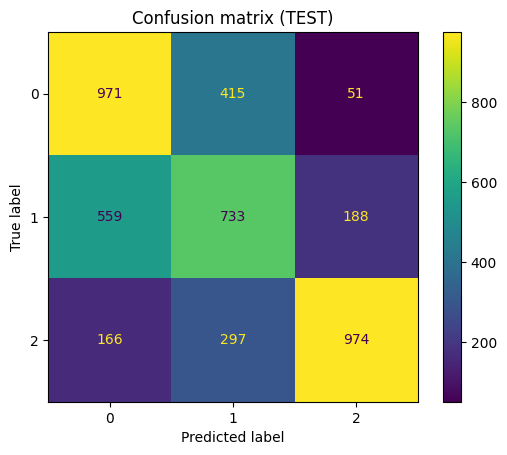

In [28]:
final_boostmodel = best_xgb  

X_trainval = pd.concat([X_train, X_validation], axis=0) #add the training features to the validation features
y_trainval = pd.concat([y_train, y_validation], axis=0) #add the training target to the validation target

final_boostmodel.fit(X_trainval, y_trainval) #fit the best model on both training and validation 

y_test_boost = final_boostmodel.predict(X_test) #Let's see how wel it does

print("--- FINAL TEST PERFORMANCE (trained on training and validation data) ---")
print(f"Accuracy: {accuracy_score(y_test, y_test_boost):.2%}")
print(classification_report(y_test, y_test_boost))

ConfusionMatrixDisplay.from_predictions(
    y_test, y_test_boost, values_format="d"
)
plt.title("Confusion matrix (TEST)")
plt.show()


**Conclusion** 

The best boosted model is the XGBoost model achieving 61.51% test accuracy. It performs slightly better than the optimized bagged model (61.55%) and the random forest (60.75%). This model does show the same characteristics as the other models. The high performing movies are very well predicted (68%!), the low performing movies are also fairly well predicted and the medium tier does the worst. In the confusion matrix, it can be seen that: 

- In the low sales category, the model correctly predicted 971 from the 1437. This is the best model for the low tier movies. The model predicted 415 movies that should be low tier sales as medium tier sales and 51 as high tier sales. 

- High sales performs with 974 accurately predicted movies from 1437, very similar performance to the bagged tree and better than random forest. 

- The biggest weakness is again medium sales: only 733 medium-sales titles are correctly classified, while many are misclassified as low sales (559) or high sales (188). 

In [ ]:
#Create a dictionary of all the best model performances
#Hardcoded because of different jupyter notenbooks :)
#Note: The dummy, logreg, KNN, SVM and NN have been trained on the trainset, the bagging, RF and boosting on train + validation (test scores shown)
accuracy_per_model = {"Dummy": 0.34, "logreg_structured": 0.566, "logreg_emb": 0.571, "KNN": 0.558, "SVM": 0.563, "NN_nlp": 0.573, "Bagging": 0.6155, "RF": 0.6075, "Boosting": 0.6151}


In [30]:
accuracyperaccuracy_per_model_df = (pd.DataFrame.from_dict(accuracy_per_model, orient="index", columns=["Accuracy"])
            .reset_index()
            .rename(columns={"index": "Model"})
            .sort_values("Accuracy", ascending=False))

accuracyperaccuracy_per_model_df

,Model,Accuracy
8,Boosting,0.6254
6,Bagging,0.6243
7,RF,0.6171
5,NN_nlp,0.5730
2,logreg_emb,0.5710
1,logreg_structured,0.5660
4,SVM,0.5630
3,KNN,0.5580
0,Dummy,0.3400


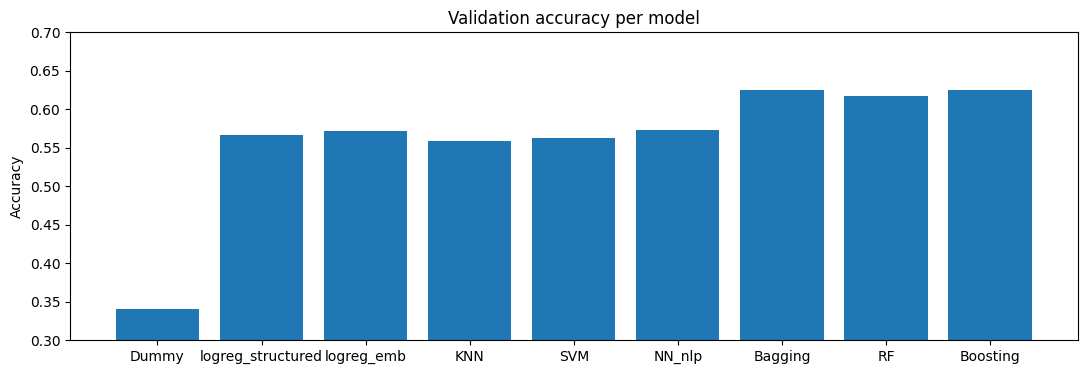

In [31]:
#barchart of the model performances
plt.figure(figsize=(13,4))
plt.bar(accuracy_per_model.keys(), accuracy_per_model.values())
plt.ylabel("Accuracy")
plt.title("Validation accuracy per model")
plt.ylim(0.3, 0.7)  #adjust the scale to make it easier to interpret 
plt.show()


# 8 Explainability 
In this chapter, the best model is explained through various explainability techniques. 
- Permutated feature importance
- Partial dependency plots
- ALE plots
- Shapley Values
- Counterfactuals


### 8.1 Permutated importance
(source: explainabnility notebook)

**Goal:** quantify how much each feature contributes to predictive performance.

**Idea:** If randomly shuffling a feature causes a large performance drop, that feature is important.

**Strengths**
- Model-agnostic (works for any model). 

**Limitations**
- Can underestimate importance when features are strongly correlated.
- Results can vary slightly; I use multiple repeats.


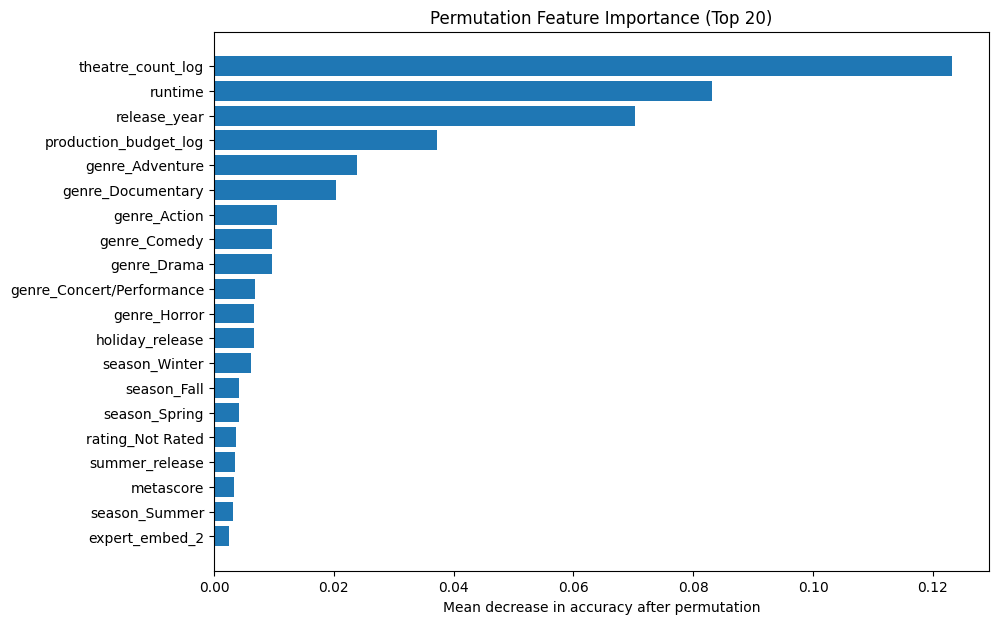

,feature,importance_mean,importance_std
4,theatre_count_log,0.123206,0.005406
2,runtime,0.083080,0.004808
5,release_year,0.070221,0.003672
3,production_budget_log,0.037199,0.004097
8,genre_Adventure,0.023909,0.003114
15,genre_Documentary,0.020293,0.003119
6,genre_Action,0.010548,0.001144
12,genre_Comedy,0.009716,0.003024
16,genre_Drama,0.009630,0.002006
13,genre_Concert/Performance,0.006788,0.001016


In [32]:
permutated = permutation_importance(
    best_xgb,
    X_validation,
    y_validation,
    scoring="accuracy",
    n_repeats=20,
    random_state=1234,
    n_jobs=-1
)

imp_df = pd.DataFrame({
    "feature": X_test.columns, #this is the only dataframe the model did not train on
    "importance_mean": permutated.importances_mean,
    "importance_std": permutated.importances_std
}).sort_values("importance_mean", ascending=False)

top_n = 20
imp_top = imp_df.head(top_n).iloc[::-1]  # reverse for horizontal bar chart

plt.figure(figsize=(10, 7))
plt.barh(imp_top["feature"], imp_top["importance_mean"])
plt.xlabel("Mean decrease in accuracy after permutation")
plt.title(f"Permutation Feature Importance (Top {top_n})")
plt.show()

imp_df.head(10)


#### 8.1.1 Reflection on permutated importance

- The theatre count, release year, runtime dominate the permutated feature importance. This is to be expected since more theatres usually contribute to more revenue and people tend to want to watch movies that are not to long or to short. Interestingly, the production buget has less impact than expected and the seasonal features do not contribute much to the prediction.
- There dont seem to be any features that leak target information
- The feature importance did not underestimate the highly correlated features (production budget, theatre count)
- The ranking does not change when the scoring metric is changed to f1_macro

## 8.2 Partial dependence plots 

This model predicts three sales classes:
- **0 = Low sales**
- **1 = Medium sales**
- **2 = High sales**

In this chapter we focus mnostly on answering two business questions:

1. **What drives a prediction toward High sales (class 2)?**
2. **What drives a prediction toward Low sales (class 0)?**

PDP shows how changing a feature affects the average predicted probability of a class.

Here we compare:
- The probability that y = Low sales
- The probability that y = High sales

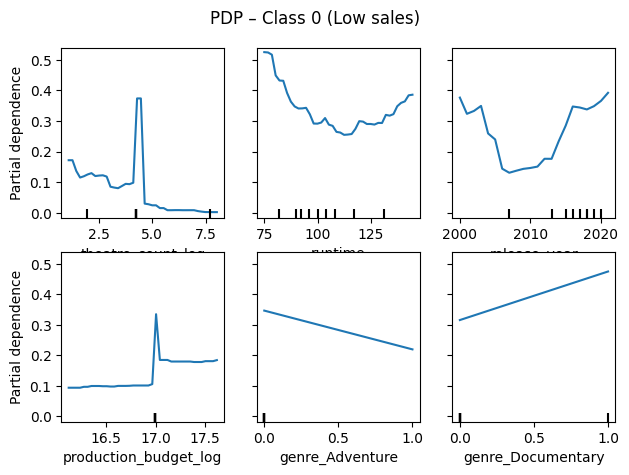

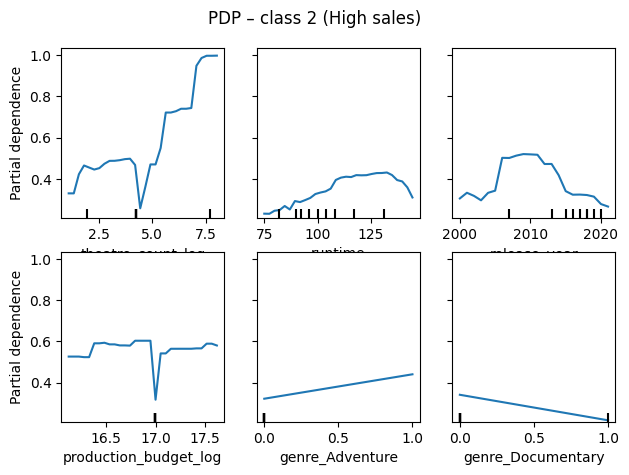

In [33]:
#define the classes for ease of use
CLASS_LOW = 0
CLASS_MED = 1
CLASS_HIGH = 2

pdp_features = imp_df["feature"].head(6).tolist()

# PDP for LOW
PartialDependenceDisplay.from_estimator(
    best_xgb,
    X_test,
    features=pdp_features,
    target=CLASS_LOW,
    grid_resolution=40
)
plt.suptitle("PDP – Class 0 (Low sales)")
plt.tight_layout()
plt.show()

# PDP for HIGH
PartialDependenceDisplay.from_estimator(
    best_xgb,
    X_test,
    features=pdp_features,
    target=CLASS_HIGH,
    grid_resolution=30
)
plt.suptitle("PDP – class 2 (High sales)")
plt.tight_layout()
plt.show()


### 8.2.1 Reflection on pdp
For the most important features, the PDP curves for class 0 (Low sales) and class 2 (High sales) show **opposite directions!**. This indicates these features act as strong discriminators on the sales and likely capture underlying drivers that differentiate low- from high-performing cases.

- **Theatre count**
    - The theatre count shows that when the count increases, less movies are predicted as class 0 and more class 2. 
    - There is a weird spike in the middle for class 0, this could be noise or this could mean that movies that have average amount of theatres are not performing well.
- **Release year**
    - It seems that movies that where release between 2005 and 2015 performed the best
- **Runtime**
    - This is very interesting, and logical at the same time. When movies are too short, they are more often predicted as class 0 and the same goes for when they are too long. 


## 8.3 SHAP values (low vs high)

SHAP decomposes a prediction into feature contributions.
Let's use SHAP for:

1. **Global:** which features matter most for class probability overall?
2. **Local:** for a single prediction, what pushed it toward Low or High?

Because this is multiclass, SHAP is computedfor the low and high class


In [34]:
import shap

X_test_df = X_test.copy()

X_shap = X_test_df.sample(min(1000, len(X_test_df)), random_state=1234) # We take a sample of the test set because SHAP is quite demanding

explainer = shap.TreeExplainer(best_xgb)
shap_values = explainer.shap_values(X_shap)

/Users/m1pro/MDDB/AI methods for business/BJJ-ai/bjj/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


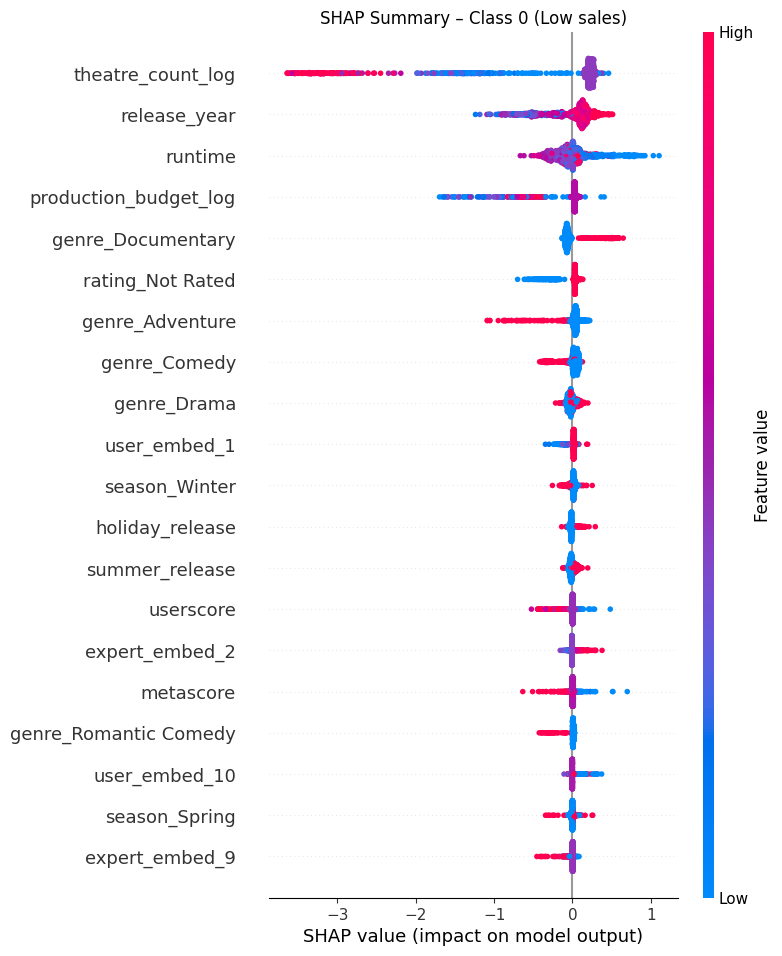

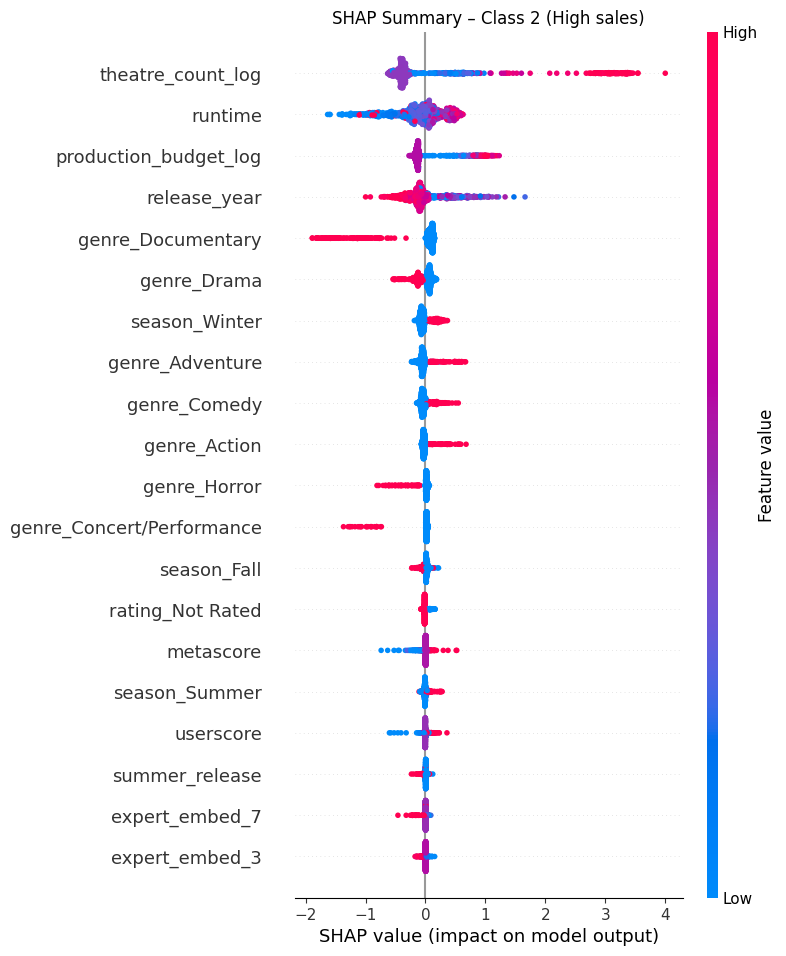

In [35]:
sv_low  = shap_values[:, :, CLASS_LOW]
sv_high = shap_values[:, :, CLASS_HIGH]

shap.summary_plot(sv_low, X_shap, show=False)
plt.title("SHAP Summary – Class 0 (Low sales)")
plt.show()

shap.summary_plot(sv_high, X_shap, show=False)
plt.title("SHAP Summary – Class 2 (High sales)")
plt.show()


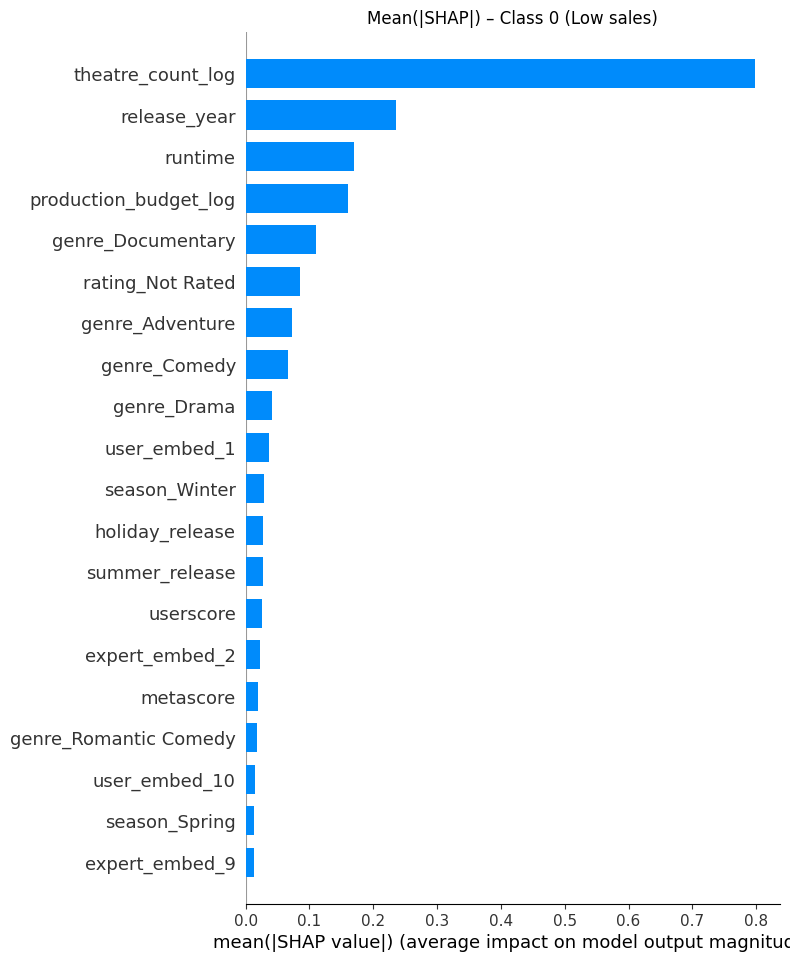

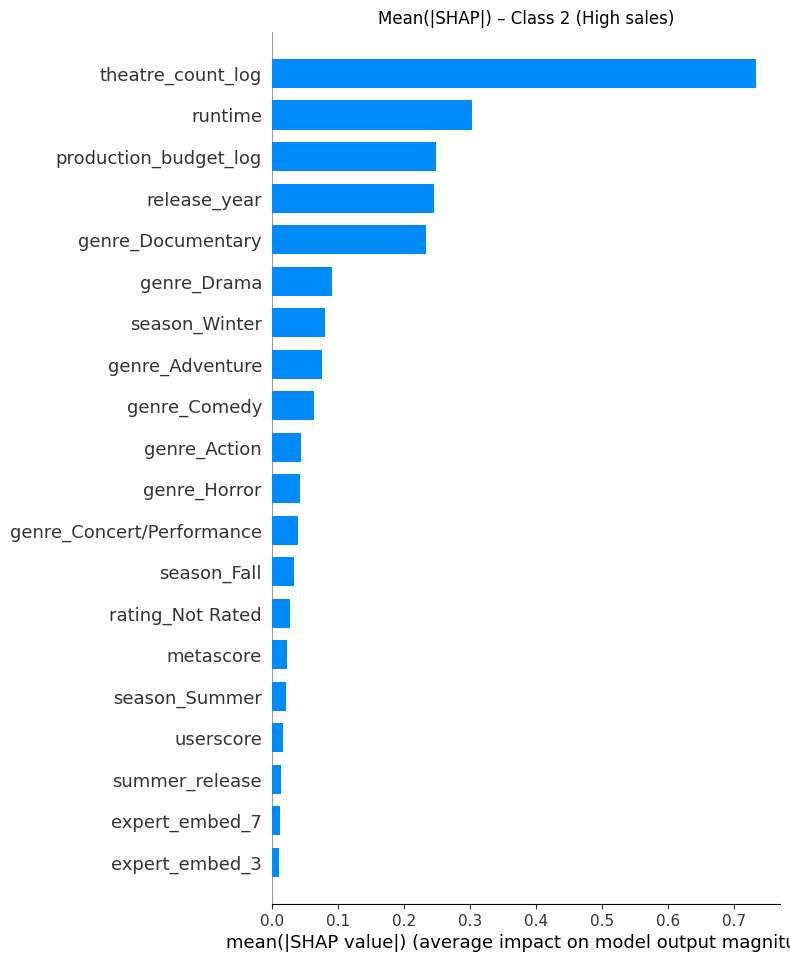

In [36]:
shap.summary_plot(sv_low,  X_shap, plot_type="bar", show=False)
plt.title("Mean(|SHAP|) – Class 0 (Low sales)")
plt.show()

shap.summary_plot(sv_high, X_shap, plot_type="bar", show=False)
plt.title("Mean(|SHAP|) – Class 2 (High sales)")
plt.show()


### 8.3.1 Reflection on SHAP values and pdp

**The dominant driver: theatre_count_log**

Across both class 0 and class 2, `theatre_count_log` is by far the most influential feature. This is a very strong signal that:

- Movies released in many theaters are predicted as high sales.
- Movies released in few theaters are predicted as low sales.

This is to be expected from a pure predictive standpoint: the number of theaters is tightly linked to box office revenue. SHAP confirms this direction clearly:
- For high sales, high values of `theatre_count_log` (red points) push predictions strongly toward class 2.
- For low sales, high values of `theatre_count_log` push predictions away from class 0.

**Reflection for the business use-case:**  
This feature is powerful, but it might be too powerful in the sense that it risks becoming a the only driver for decisions, to allocate marketing budget the amount of theatres is useful information but not everything. If we want a model that helps allocate marketing budget early, we need to be careful:

- If theatre count is only known after marketing/distribution planning, then using it makes the prediction less actionable for budgeting.
- If theatre count is known at the time we allocate marketing budget, then it’s fair game but it also means the model may be predicting wide release = high sales, which is accurate but not very insightful.

This creates a key insight on the model: this model is highly predictive, but the main driver may give more information on decisions after the movie has been made than typical demand signals.

**Strong alignment between PDP and SHAP**

Examples where PDP and SHAP align well:

- *genre_Documentary* 
  - PDP: documentary increases probability of low sales and decreases probability of high sales.  
  - SHAP: Documentary = 1 pushes predictions toward low and away from high.  
  Interpretation: documentaries are systematically associated with lower box office tiers in this dataset.

- *genre_Adventure*
  - PDP: Adventure decreases probability of low sales and increases probability of high sales.  
  - SHAP: Adventure = 1 contributes negatively to low and positively toward high.  
  Interpretation: adventure titles are more likely to land in higher sales tiers.

**Runtime and release year: informative, but more nuanced**
- Runtime is always in the top features in SHAP, but the relationship is not purely linear:
- SHAP suggests shorter runtimes tend to push predictions toward low sales, while longer runtimes tend to push toward high sales.
- PDP for high sales shows a peak around middle to high runtime, suggesting that there is an optimal runtime in instead of the longer the better

This likely captures blockbusters that often have longer runtimes.

Release year ranks high in SHAP for both classes, but the direction differs:

- For high sales, newer years appear to push predictions slightly away from high .
- PDP curves suggest time effects that are not strictly monotonic and may reflect market changes.

This could reflect the dataset rather than a true industry trend. 

**Production budget**

- Production_budget_log shows up more strongly for high sales in SHAP. The general intuition is that higher budgets are often associated with higher box office.

However, the low-sales pdp shows that higher budgets can also increase low-sales probability. Which could be the case because in the EDA we found that some expensive movies did not perform well.

### What SHAP adds beyond PDP: global ranking + directionality within feature ranges

The SHAP beeswarm plots add two key insights that PDP alone cannot:

**Direction (red vs blue):**  
   For the most important features, the color shows consistent direction:
   - High theatre count: pushes toward high sales and low theatre count → pushes toward low sales.
   - Documentary: pushes toward low and away from high.
   - Adventure: away from low and toward high.
   - Runtime: longer tends to support high; shorter supports low.


# Results
### Subquestion 1  
**How are the features in the original dataframes related to the sales tiers of movies?**  
In the EDA phase, we found that the there are strong, moderate and weak predictors in the spearman correlation analysis. From the features mentioned in the subquestion userscores and metascores were the weakest predictors. The runtime and release year are moderate predictors with longer runtimes being slighlty correlated with higher revenue. This could reflect that blockbusters have longer runtimes or that audiences perceive longer movies as more worthy of their money. Release year has a moderate negative correlation with the target. The strongest correlated features are theatre count and production budget, both having r > 0.7. Which basically means that the more theatres the movie is screened and the higher the budget the more they earn. 

To compliment the correlation analysis, we found that after modelling the theatre count shows a similar pattern as the EDA. Movies that are screened in more theatres most often are predicted as high tier sales. Likewise, the less theatres they are screened in, the more movies are predicted as low tier sales. The release year shows an interesting pattern in contrast to the correlation analysis, with movies released between 2005 and 2015 being predicted more often as high tier sales than release years before 2005 and after 2015. The runtime also shows a similar pattern after modelling as it does in the raw datasets. Runtimes have a sweet spot in the medium to high values.

Interestingly, the best model also relied on specific genres for it's prediction. Something that we did not see in the EDA phase. 
The genres documentary and adventure stand out the most, with documentaries showing a negative impact on sales and adventure a positive impact on sales. This is valuable information on which genres perform better once they are put on the big screen. 

Overal it is clear that the features with the highest correlation also contribute the most to the prediction of the model. 

### Subquestion 2  
**How well can different machine learning models predict the sales tier of a movie?**  
To aswer this question lets first again clarify the different sales tiers. A movie is considered to by low tier sales when it has a revenue of $84,799 which is the bottom 33%, a movie is consideren medium tier when it has a revenue between $84,799 - $2,636,589 which is the middle 34% and the high tier movies have a revenue of more than $2,636,589 which accounts for the top 33%. To predict whether a movie was low, medium or high tier sales the following base models were used to see how well an 'easy' model performs: 
- Dummy model 
- A logistic regression model without feature embeddings
- A logistic regression model with feature embeddings
- A KNN model
- A support vector machine 

From these models, the logistic regression with feature embeddings did the best and was therefore used as the basemodel. This model had 57.1% accuracy. To try and beat this accuracy score the following models were built: 
- A neureal network 
- A bagged tree ensemble
- A random forest model 
- A boosted tree ensemble 

From these model, the boosted model performed the best with 61.55% accuracy. See the figure below for the comparison graph. 

![Model Diagram](./models.png)

### Subquestion 3  
**To what extent does adding transformers of review titles and/or movie summaries improve prediction performance compared to models using only structured features?**  
To find out whether the transformer embeddings add any value to the prediction of the models, the basemodel was tested on both the dataset with embedding and without. The basemodel showed that the transformer embedding slightly improve performance. Therefore, the models afterwards were all fitted on the dataset with the embeddigs. The embeddings give information on whether reviews have any impact on sales, which they apparently do. See the graph below for the difference:

![Embeddings vs structured](./embeddings.png)


- Structured features only: 56.6% accuracy
- Embeddings added: 57.1% accuracy

### Subquestion 4  
**Can we identify review topics associated with high or low sales tiers, and do these insights lead to model performance growth?**  
To find out whether the review topics embeddings created with BERT had any effect on the models performance, the embeddings have been added at to the modelling dataset seperately. All the best models (treemodels) have been fitted on this new dataset to see whether there is any improvement. The BERT embeddings increased the performance of the best model (XGBpoost) by 0.12%. Although there is a very slight improvement, the dataset used was way bigger than the dataset without BERT embeddings. To keep the model scalable, the research decided not to include the BERT embeddings in the final dataset. 

## Final Conclusion

We can predict whether a movie's box-office sales tier will be low, medium, or high with moderate accuracy using metacritic ratings, structured metadata, and text-derived features. The best performing model was a tree-based boosting model (XGBoost), achieving 61.51% test accuracy, clearly outperforming the baseline logistic regression model at 57.1%. This improvement shows that non-linear models capture meaningful patterns and interactions in the data that simpler models miss.

However, the explainability analyses (permutation importance, PDP, and SHAP) show that predictive performance is driven heavily by a small set of features, particularly theatre count and release year. This is an important finding for the business use-case: while these variables strongly improve prediction, they are not directly controllable through marketing budget and they may reflect strategic studio decisions rather than consumer demand. As a result, the model is less suited as an “early demand predictor” and more suited as a decision support tool.

the model can support budget allocation by indicating which movies are most likely to end up in the high versus low tier once key features are known. Furthermore, it can function to show potential risk, finding titles that are expected to perform poorly.

### Recommendation
To align the model with the business goal, the best next step is to create two versions:
1. Includes theatre count: best for forecasting once release/distribution is set.
2. Excludes theatre count (and possibly release year): better for earlier marketing decisions, even if accuracy decreases.
